# GPU Test

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 37.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
"""
Skin cancer lesion classification using the HAM10000 dataset
Autokeras to find the best model. 
Dataset link:
https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000
Data description: 
https://arxiv.org/ftp/arxiv/papers/1803/1803.10417.pdf
The 7 classes of skin cancer lesions included in this dataset are:
Melanocytic nevi (nv)
Melanoma (mel)
Benign keratosis-like lesions (bkl)
Basal cell carcinoma (bcc) 
Actinic keratoses (akiec)
Vascular lesions (vas)
Dermatofibroma (df)
"""

'\nSkin cancer lesion classification using the HAM10000 dataset\nAutokeras to find the best model. \nDataset link:\nhttps://www.kaggle.com/kmader/skin-cancer-mnist-ham10000\nData description: \nhttps://arxiv.org/ftp/arxiv/papers/1803/1803.10417.pdf\nThe 7 classes of skin cancer lesions included in this dataset are:\nMelanocytic nevi (nv)\nMelanoma (mel)\nBenign keratosis-like lesions (bkl)\nBasal cell carcinoma (bcc) \nActinic keratoses (akiec)\nVascular lesions (vas)\nDermatofibroma (df)\n'

# Import Default Packages

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import io
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [5]:
pip install autokeras

     |████████████████████████████████| 160 kB 5.3 MB/s 
     |████████████████████████████████| 133 kB 53.2 MB/s 
     |████████████████████████████████| 462 kB 80.9 MB/s 


In [6]:
import autokeras as ak

# Upload and Download File

In [7]:
from google.colab import drive
drive.mount('/content/drive')
# have to upload the files on drive 
# 참고 : https://vision-ai.tistory.com/entry/%EC%BD%94%EB%9E%A9%EC%97%90%EC%84%9C-%EB%93%9C%EB%9D%BC%EC%9D%B4%EB%B8%8C%EC%9D%98-csv-%ED%8C%8C%EC%9D%BC-%EC%9D%BD%EA%B8%B0
# 참고 : https://growthj.link/python-%EA%B5%AC%EA%B8%80-colab%EC%9C%BC%EB%A1%9C-pd-read-csv-%ED%99%9C%EC%9A%A9%ED%95%98%EB%8A%94-%EB%B0%A9%EB%B2%95/

skin_df = pd.read_csv("/content/drive/MyDrive/Thesis/dataset/HAM10000_metadata")

skin_df.head()

Mounted at /content/drive


,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


# Convert Label

In [8]:
SIZE_WIDTH = 50
SIZE_HEIGHT = 38


# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))


skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization        dataset  label  
1617             face   vidir_modern      4  
8128  lower extremity    vienna_dias      5  
2168             back      rosendahl      4  
1090            trunk  vidir_molemax      2  
775

# Data distribution visualization

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


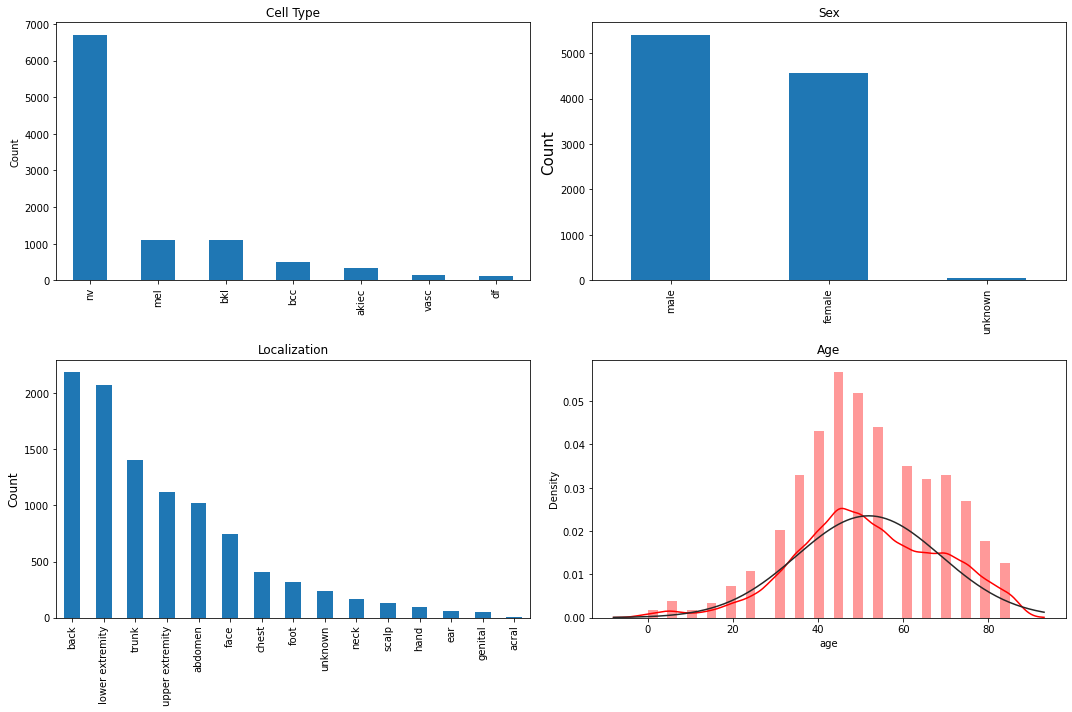

In [9]:
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')


ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()


The dataset is not balanced -> need to be balanced

# Distribution of data into various classes 

In [10]:
from sklearn.utils import resample
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


# Balance data

In [11]:
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

In [12]:
n_samples=500
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [13]:
#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
print(skin_df_balanced['label'].value_counts())

0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


Now it's a balanced dataset 

In [14]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/content/drive/MyDrive/Thesis/dataset/', '*', '*.jpg'))}

In [15]:
#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)

In [16]:
print(image_path)

{'ISIC_0033325': '/content/drive/MyDrive/Thesis/dataset/HAM10000_images_part_2/ISIC_0033325.jpg', 'ISIC_0033323': '/content/drive/MyDrive/Thesis/dataset/HAM10000_images_part_2/ISIC_0033323.jpg', 'ISIC_0033334': '/content/drive/MyDrive/Thesis/dataset/HAM10000_images_part_2/ISIC_0033334.jpg', 'ISIC_0033326': '/content/drive/MyDrive/Thesis/dataset/HAM10000_images_part_2/ISIC_0033326.jpg', 'ISIC_0033333': '/content/drive/MyDrive/Thesis/dataset/HAM10000_images_part_2/ISIC_0033333.jpg', 'ISIC_0033328': '/content/drive/MyDrive/Thesis/dataset/HAM10000_images_part_2/ISIC_0033328.jpg', 'ISIC_0033327': '/content/drive/MyDrive/Thesis/dataset/HAM10000_images_part_2/ISIC_0033327.jpg', 'ISIC_0033324': '/content/drive/MyDrive/Thesis/dataset/HAM10000_images_part_2/ISIC_0033324.jpg', 'ISIC_0033320': '/content/drive/MyDrive/Thesis/dataset/HAM10000_images_part_2/ISIC_0033320.jpg', 'ISIC_0033331': '/content/drive/MyDrive/Thesis/dataset/HAM10000_images_part_2/ISIC_0033331.jpg', 'ISIC_0033321': '/content/dri

In [17]:
#Use the path to read and resize images .
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE_WIDTH, SIZE_HEIGHT))))

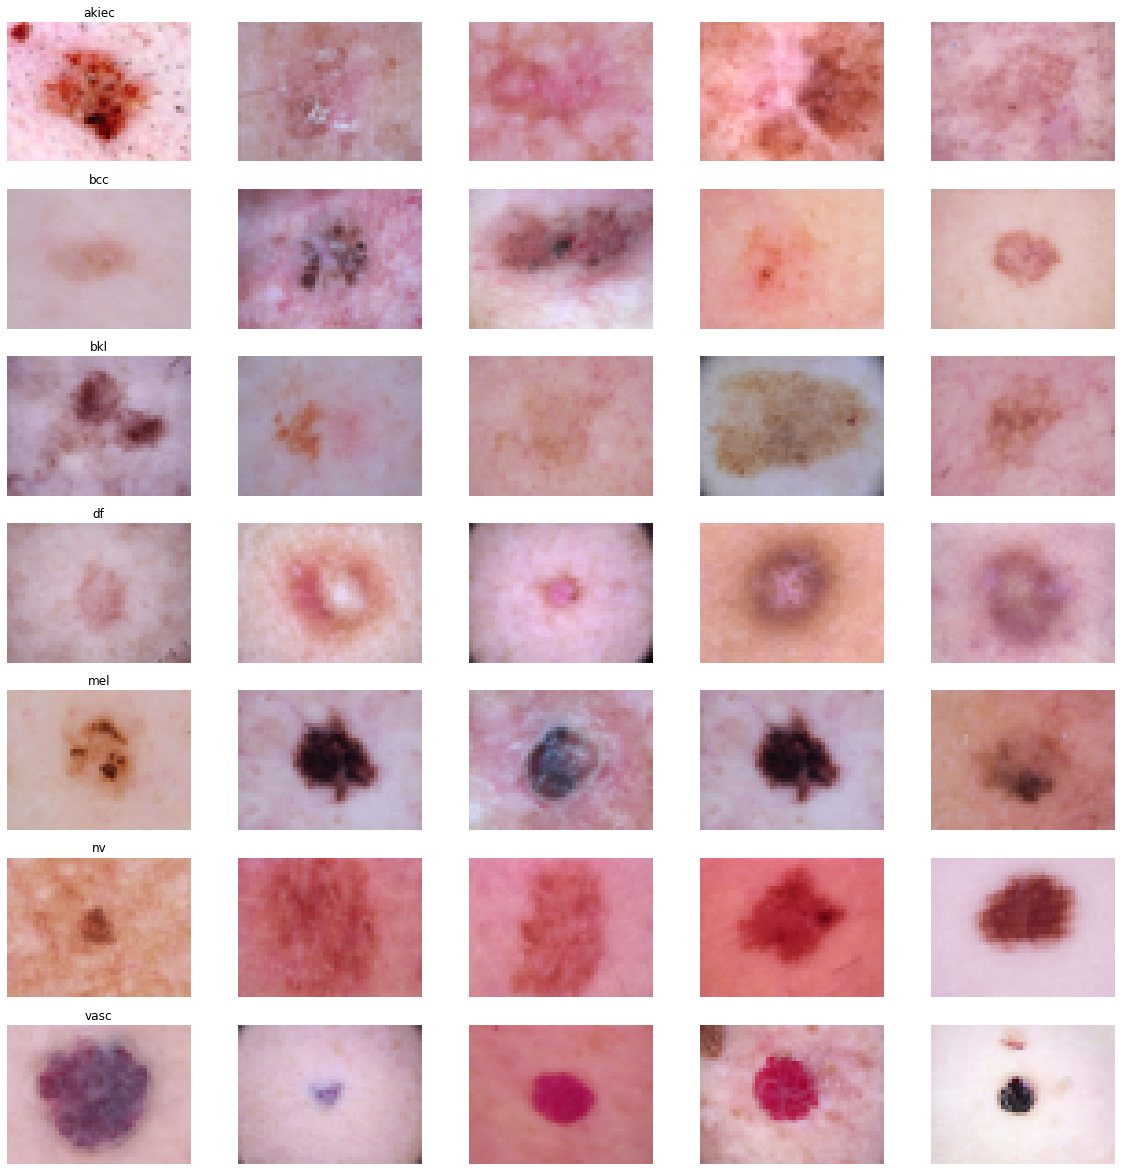

In [18]:
n_samples = 5  #number of samples for plot 

# Plot
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')


#Convert dataframe column of images into numpy array

In [19]:
X = np.asarray(skin_df_balanced['image'].tolist())

In [20]:
X = X/255. # Scale values to 0-1. 

In [21]:
Y=skin_df_balanced['label'] #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem

In [22]:
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)
                                                            # 25% of test size 

# Dedine the model

In [31]:
#I've used autokeras to find out the best model for this problem.

num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE_HEIGHT, SIZE_WIDTH, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 36, 48, 256)       7168      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 18, 24, 256)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 18, 24, 256)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 22, 128)       295040    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 11, 128)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 8, 11, 128)       

In [33]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

# Train

In [34]:
batch_size = 16 
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate( x_test, y_test)
print('Test accuracy:', score[1])

Epoch 1/50
165/165 - 9s - loss: 1.9077 - acc: 0.1966 - val_loss: 1.7778 - val_acc: 0.2457 - 9s/epoch - 56ms/step
Epoch 2/50
165/165 - 8s - loss: 1.6452 - acc: 0.3200 - val_loss: 1.5228 - val_acc: 0.4160 - 8s/epoch - 50ms/step
Epoch 3/50
165/165 - 8s - loss: 1.4984 - acc: 0.3840 - val_loss: 1.4610 - val_acc: 0.3897 - 8s/epoch - 51ms/step
Epoch 4/50
165/165 - 9s - loss: 1.4369 - acc: 0.4236 - val_loss: 1.3853 - val_acc: 0.4331 - 9s/epoch - 52ms/step
Epoch 5/50
165/165 - 9s - loss: 1.4114 - acc: 0.4297 - val_loss: 1.3662 - val_acc: 0.4389 - 9s/epoch - 52ms/step
Epoch 6/50
165/165 - 8s - loss: 1.3365 - acc: 0.4648 - val_loss: 1.3256 - val_acc: 0.4537 - 8s/epoch - 49ms/step
Epoch 7/50
165/165 - 8s - loss: 1.2485 - acc: 0.5109 - val_loss: 1.2586 - val_acc: 0.4674 - 8s/epoch - 50ms/step
Epoch 8/50
165/165 - 8s - loss: 1.2685 - acc: 0.5112 - val_loss: 1.2150 - val_acc: 0.4994 - 8s/epoch - 50ms/step
Epoch 9/50
165/165 - 8s - loss: 1.1826 - acc: 0.5371 - val_loss: 1.1499 - val_acc: 0.5429 - 8s/e

# Plot the training and validation accuracy and loss at each epoch

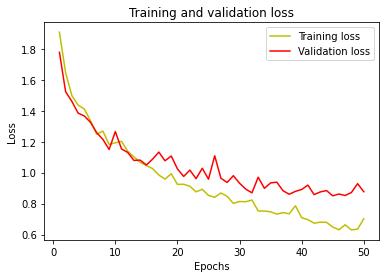

In [35]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

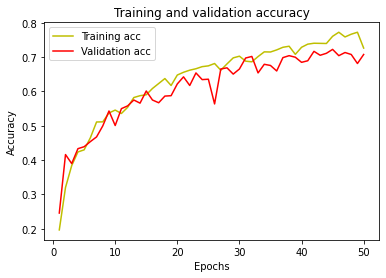

In [36]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Prediction on test data

In [37]:
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

#Print confusion matrix

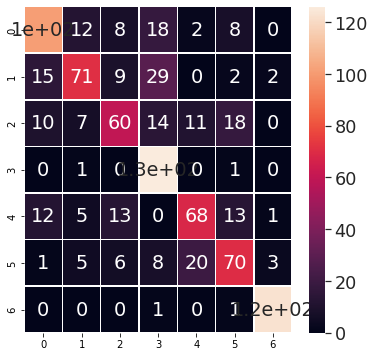

In [38]:
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

#PLot fractional incorrect misclassifications

Text(0, 0.5, 'Fraction of incorrect predictions')

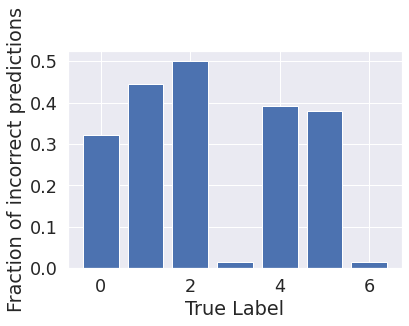

In [39]:
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')